# McNulty Modeling - Non-Parametric Models
We will approach the modeling now with the new league categories, scaled down from 8 to 3.
Our goal will be to maximize Recall for the categories, especially the top-tier category, Contender.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer

from sklearn import svm

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib as mpl
import scipy.stats as st

from imblearn.over_sampling import RandomOverSampler

import pickle
from collections import Counter

In [2]:
# Get pickles for new league dfs
with open('sc_newLeagues_scaled.pickle','rb') as read_file:
    scs = pickle.load(read_file)

# Pickle opening code
with open('sc_newLeagues_noscale.pickle','rb') as read_file:
    scns = pickle.load(read_file)

### Confusion Matrix Function

In [193]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), 
                           labelsize=18, fontsize=15, numsize=20, cmap=None):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": numsize}, cmap=cmap )
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=labelsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=labelsize)
    plt.ylabel('TRUE', fontsize=fontsize)
    plt.xlabel('PREDICTED', fontsize=fontsize)
    return fig

## Create DF Variants for Modeling

#### Target = LeagueIndex

In [7]:
# Our target across all models
y = scs['LeagueIndex']

### Non-Parametric Model Features
Only taking multicollinearity into account  
- HoursPerWeek
- APM
- UniqueHotkeys
- MinimapAttacks
- MinimapRightClicks
- NumberOfPACs
- ActionsInPAC
- WorkersMade
- UniqueUnitsMade
- ComplexAbilityUsed

In [8]:
# Unscaled non-parametric features
np_noscal = scns.copy()
np_noscal = np_noscal[['HoursPerWeek', 'APM', 'UniqueHotkeys', 'MinimapAttacks',
                       'MinimapRightClicks', 'NumberOfPACs', 'ActionsInPAC', 
                       'WorkersMade', 'UniqueUnitsMade', 'ComplexAbilityUsed']]

In [9]:
# Scaled non-parametric features
np_scaled = scs.copy()
np_scaled = np_scaled[['HoursPerWeek', 'APM', 'UniqueHotkeys', 'MinimapAttacks',
                       'MinimapRightClicks', 'NumberOfPACs', 'ActionsInPAC', 
                       'WorkersMade', 'UniqueUnitsMade', 'ComplexAbilityUsed']]

### Parametric Model Features
Very few due to general lack of normality in the dataset
- APM
- NumberOfPACs
- UniqueUnitsMade

In [10]:
# Unscaled parametric features
par_noscal = scns.copy()
par_noscal = par_noscal[['APM', 'NumberOfPACs', 'UniqueUnitsMade']]

In [11]:
# Scaled parametric features
par_scaled = scs.copy()
par_scaled = par_scaled[['APM', 'NumberOfPACs', 'UniqueUnitsMade']]

## Non-Parametric Approaches
Because so few features survived the normality tests we'll start with non-parametric models
- KNN
- Support Vector Classifiers
- Random Forests 

### KNN
- Since KNN is based on Euclidean distance we'll used the scaled version of the non-parametric data.

### KNN Simple train_test_split Test

In [136]:
# Set the split to 75/25 train/test
X_train, X_test, y_train, y_test = train_test_split(np_scaled, y, test_size=0.25, random_state=0)

In [13]:
# Train on training set, and Test on testing set with K=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [18]:
# Scores
print("Accuracy Score:", metrics.accuracy_score(y_test, y_pred))
print("Overall Recall:" , metrics.recall_score(y_test, y_pred, average=None))
print("Contender Class Recall:" , metrics.recall_score(y_test, y_pred, average=None, labels=[3]))

Accuracy Score: 0.6121718377088305
Overall Recall: [0.64620939 0.65535248 0.46629213]
Contender Class Recall: [0.46629213]


In [103]:
confusion_matrix(y_test, y_pred)

array([[179,  95,   3],
       [ 88, 251,  44],
       [ 14,  81,  83]])

- Pretty awful recall score. Definitely need to do better

In [19]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[179,  95,   3],
       [ 88, 251,  44],
       [ 14,  81,  83]])

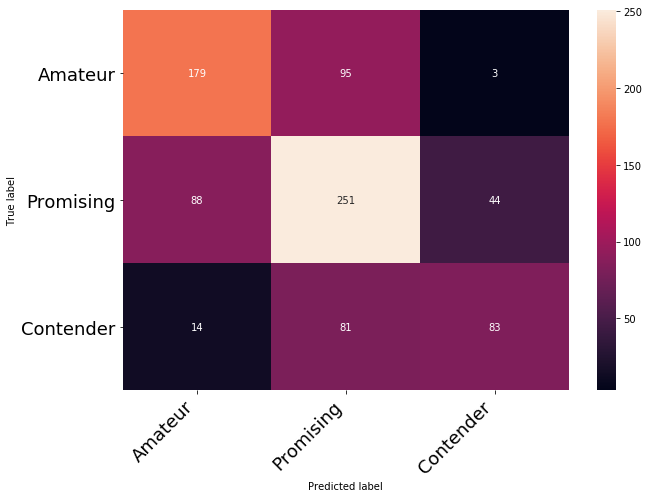

In [21]:
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      ['Amateur', 'Promising', 'Contender'])
plt.savefig('knn_train_test_split_confusion-test.png')

### Cross-Validated search for optimal value of K

In [28]:
# Make custom scorer
recallScorer = make_scorer(metrics.recall_score, average=None, labels=[3])

In [29]:
# Search for an optimal value of K for KNN using 10-fold CV on the training sets, and Recall as the scorer
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring=recallScorer)
    k_scores.append(scores.mean())
print(k_scores)
print('Max score:',max(k_scores))

[0.4312594268476621, 0.26704374057315233, 0.45837104072398194, 0.3423076923076923, 0.4042232277526395, 0.35584464555052786, 0.40610859728506793, 0.3481523378582202, 0.37711161387631975, 0.3520361990950226, 0.379185520361991, 0.3462292609351433, 0.3597662141779788, 0.35199849170437403, 0.3617269984917044, 0.35015082956259425, 0.35015082956259425, 0.34626696832579185, 0.33657616892911013, 0.3461915535444947, 0.34030920060331826, 0.3500754147812971, 0.34423076923076923, 0.3346907993966817, 0.3384238310708899, 0.32688536953242836, 0.33453996983408746, 0.3326546003016591, 0.3289592760180996, 0.31534690799396675]
Max score: 0.45837104072398194


In [30]:
# Write a little function to return the best k scores of the bunch
def best_K_scores(k_scores):
    best_K_values = []
    count = 0
    for i in k_scores:
        count += 1
        if i == max(k_scores):
            best_K_values.append(['K value: ' + str(count), 'Score: ' + str(i)])
    print(best_K_values)       
best_K_scores(k_scores)

[['K value: 3', 'Score: 0.45837104072398194']]


Text(0, 0.5, 'Cross-Validated Accuracy')

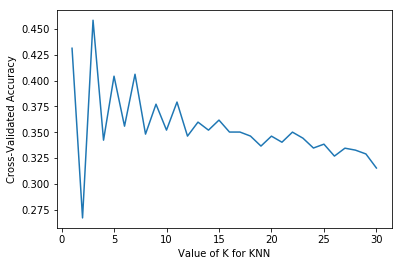

In [31]:
# Plot the scores
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

- Pretty wild scoring curve. 
- Overall Recall is low though. Much lower than what we would want, but in line with the first Recall score. 

In [33]:
k_range = list(range(1, 100))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring=recallScorer)
    k_scores.append(scores.mean())
print(k_scores)
print('Max score:',max(k_scores))

[0.4312594268476621, 0.26704374057315233, 0.45837104072398194, 0.3423076923076923, 0.4042232277526395, 0.35584464555052786, 0.40610859728506793, 0.3481523378582202, 0.37711161387631975, 0.3520361990950226, 0.379185520361991, 0.3462292609351433, 0.3597662141779788, 0.35199849170437403, 0.3617269984917044, 0.35015082956259425, 0.35015082956259425, 0.34626696832579185, 0.33657616892911013, 0.3461915535444947, 0.34030920060331826, 0.3500754147812971, 0.34423076923076923, 0.3346907993966817, 0.3384238310708899, 0.32688536953242836, 0.33453996983408746, 0.3326546003016591, 0.3289592760180996, 0.31534690799396675, 0.3308069381598793, 0.3173076923076923, 0.31342383107088995, 0.31534690799396686, 0.32119155354449475, 0.3173453996983409, 0.32699849170437406, 0.3172699849170438, 0.3211161387631976, 0.3172699849170438, 0.3230769230769231, 0.3095399698340875, 0.30754147812971344, 0.31146304675716446, 0.3115007541478129, 0.3018099547511312, 0.2998491704374057, 0.2940422322775264, 0.29981146304675715

In [34]:
best_K_scores(k_scores)

[['K value: 3', 'Score: 0.45837104072398194']]


Text(0, 0.5, 'Cross-Validated Accuracy')

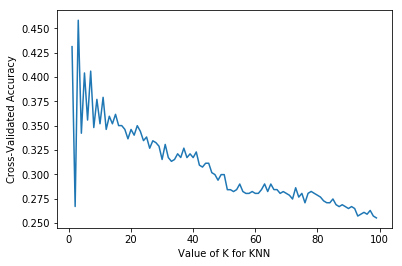

In [35]:
# Plot the scores
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [36]:
# Train on training set, and Test on testing set with K=3, the best of the K Recall values
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
score = cross_val_score(knn, X_test, y_test, cv=10, scoring=recallScorer)

In [37]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

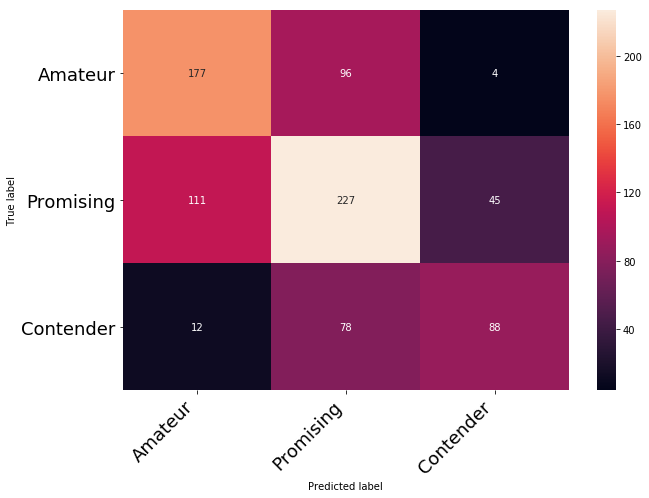

In [38]:
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      ['Amateur', 'Promising', 'Contender'])

#### Change weight parameter to 'distance' in KNN

In [41]:
# Trying using the 'distance' for the weights parameter in the classifier, K=3
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train, y_train)
score = cross_val_score(knn, X_train, y_train, cv=10, scoring=recallScorer)
print(score)
print(score.mean())

[0.46153846 0.48076923 0.46153846 0.48076923 0.53846154 0.40384615
 0.53846154 0.41176471 0.50980392 0.47058824]
0.4757541478129713


### KNN-CV Test Results
Perform test on the KNN-CV set with the optimized neighbors and weights parameters.

In [50]:
y_pred = knn.predict(X_test)

In [51]:
print("Accuracy Score:", metrics.accuracy_score(y_test, y_pred))
print("Overall Recall:" , metrics.recall_score(y_test, y_pred, average=None))
print("Contender Class Recall:" , metrics.recall_score(y_test, y_pred, average=None, labels=[3]))

Accuracy Score: 0.6014319809069213
Overall Recall: [0.60649819 0.63707572 0.51685393]
Contender Class Recall: [0.51685393]


In [45]:
metrics.confusion_matrix(y_test, y_pred)

array([[168, 103,   6],
       [ 87, 244,  52],
       [  7,  79,  92]])

- Slight improvement in Contender Recall and overall Recall. We've gotten above 0.5!

### Oversampling Training Data
See if oversampling to even out classes helps

In [139]:
# Oversample the classes
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)

In [58]:
# Test K value ranges 1-100 with oversampled data
k_range = list(range(1, 101))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn, X_resampled, y_resampled, cv=10, scoring=recallScorer)
    k_scores.append(scores.mean())

In [59]:
# Pull out the best score
best_K_scores(k_scores)

[['K value: 20', 'Score: 0.9653773201463217']]


- That is a __vast improvement__ in the Recall score, and a much higher neighbor count. 
- Let's see who this pans out in test.

Text(0, 0.5, 'Cross-Validated Accuracy')

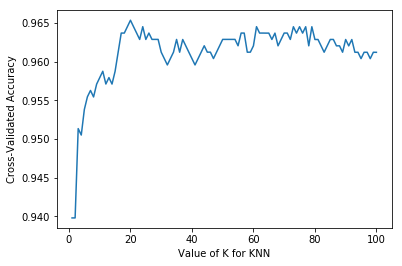

In [60]:
# Plot the scores
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [61]:
# Train with oversampled data
knn = KNeighborsClassifier(n_neighbors=20, weights='distance')
knn.fit(X_resampled, y_resampled)
y_pred = knn.predict(X_resampled)
score = cross_val_score(knn, X_resampled, y_resampled, cv=10, scoring=recallScorer)
score.mean()

0.9653773201463217

### Oversampled KNN-CV Test Results

In [62]:
y_pred = knn.predict(X_test)

In [63]:
print("Accuracy Score:", metrics.accuracy_score(y_test, y_pred))
print("Overall Recall:" , metrics.recall_score(y_test, y_pred, average=None))
print("Contender Class Recall:" , metrics.recall_score(y_test, y_pred, average=None, labels=[3]))

Accuracy Score: 0.6336515513126492
Overall Recall: [0.77256318 0.46997389 0.76966292]
Contender Class Recall: [0.76966292]


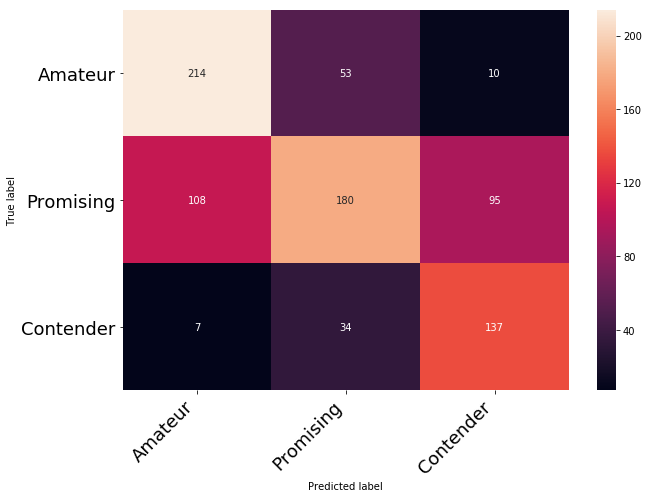

In [64]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      ['Amateur', 'Promising', 'Contender'])

- Really good improvement for Contender recall, which is the primary goal. 
- However, recall for the Promising category has really suffered. May be willing to accept this though. 
- So far __oversampled KNN-CV has the best performance for Contender__.

### Support Vector Classifiers
Train and test with Support Vector Classifiers.

### Simple Training Splits
We'll only be looking at the training scores for these.

In [65]:
# Linear Kernel 
linear_svc = SVC(C=1, kernel='linear')
linear_svc.fit(X_train, y_train)
score = linear_svc.score(X_train, y_train)
score

0.6610978520286396

In [67]:
# Polynomial Kernel
poly_svc = SVC(C=1, kernel='poly', gamma=1)
poly_svc.fit(X_train, y_train)
score = poly_svc.score(X_train, y_train)
score

0.7291169451073986

- Worth noting that the poly kernel took forever to run. Easily a minute or two. 

In [68]:
# Sigmoid Kernel
sig_svc = SVC(C=1, kernel='sigmoid', gamma=1)
sig_svc.fit(X_train, y_train)
score = sig_svc.score(X_train, y_train)
score

0.4192521877486078

In [69]:
# RBF Kernel
rbf_svc = SVC(C=1, kernel='rbf', gamma=1)
rbf_svc.fit(X_train, y_train)
score = rbf_svc.score(X_train, y_train)
score

0.9212410501193318

- The Radial Basis Function had the best result, at least on the training data. 
- I'm pretty suspicious of this though. RBF is a very dynamic model and it may be significantly overfitting on the training ata. 

### Cross-Validated
We'll try cross validation on the SVC modeling. We'll stick with oversampled, since that seemed to yield better results.

In [140]:
# Linear Kernel CV
linear_svc = SVC(C=1, kernel='linear')
linear_cv_scores = cross_val_score(linear_svc, X_resampled, y_resampled, cv=10, scoring=recallScorer)
print(linear_cv_scores)
print('Linear Kernel CV Score:', linear_cv_scores.mean())
print("Accuracy: %0.2f (+/- %0.2f)" % (linear_cv_scores.mean(), linear_cv_scores.std() * 2))

[0.75409836 0.67768595 0.66115702 0.65289256 0.73553719 0.7107438
 0.73553719 0.69421488 0.75206612 0.7107438 ]
Linear Kernel CV Score: 0.7084676873052432
Accuracy: 0.71 (+/- 0.07)


- Overall not bad on train. Let's look at test. 

### SVC Linear Kernel Test

In [141]:
linear_svc.fit(X_resampled, y_resampled)
y_pred = linear_svc.predict(X_test)

In [142]:
print("Accuracy Score:", metrics.accuracy_score(y_test, y_pred))
print("Overall Recall:" , metrics.recall_score(y_test, y_pred, average=None))
print("Contender Class Recall:" , metrics.recall_score(y_test, y_pred, average=None, labels=[3]))

Accuracy Score: 0.665871121718377
Overall Recall: [0.79783394 0.52219321 0.76966292]
Contender Class Recall: [0.76966292]


- Wow, better Recall overall for all classes. 
- Great to see improvements for 

In [ ]:
#print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), labelsize=18, fontsize=15, cmap=None)

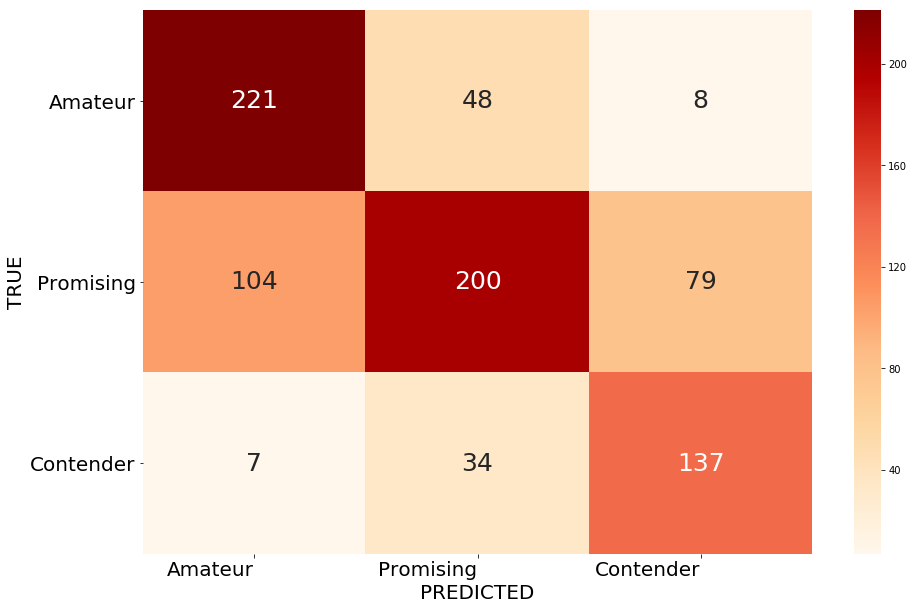

In [194]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), 
                            ['Amateur', 'Promising', 'Contender'], 
                            figsize=(15,10), cmap='OrRd',
                            labelsize=20, fontsize=20, numsize=25)

- Good performance on Contender. Overall precision is about the same. 

In [85]:
# Poly Kernel CV
poly_svc = SVC(C=1, kernel='poly', gamma='auto')
poly_cv_scores = cross_val_score(poly_svc, X_resampled, y_resampled, cv=10, scoring=recallScorer)
print(poly_cv_scores)
print('Polynomial Kernel CV Score:', poly_cv_scores.mean())
print("Accuracy: %0.2f (+/- %0.2f)" % (poly_cv_scores.mean(), poly_cv_scores.std() * 2))

[0.60655738 0.49586777 0.52892562 0.56198347 0.59504132 0.5785124
 0.56198347 0.62809917 0.63636364 0.57024793]
Polynomial Kernel CV Score: 0.576358217043761
Accuracy: 0.58 (+/- 0.08)


- Not horrible, but not better than linear.

In [86]:
# Sigmoid Kernel CV
sig_svc = SVC(C=1, kernel='sigmoid', gamma='auto')
sig_cv_scores = cross_val_score(sig_svc, X_resampled, y_resampled, cv=10, scoring=recallScorer)
print(sig_cv_scores)
print('Sigmoid Kernel CV Score:', sig_cv_scores.mean())
print("Accuracy: %0.2f (+/- %0.2f)" % (sig_cv_scores.mean(), sig_cv_scores.std() * 2))

[0.69672131 0.58677686 0.73553719 0.66115702 0.70247934 0.58677686
 0.74380165 0.6446281  0.76033058 0.66942149]
Sigmoid Kernel CV Score: 0.6787630402384501
Accuracy: 0.68 (+/- 0.12)


- Not that great.

In [87]:
# RBF Kernel CV
rbf_svc = SVC(C=1, kernel='poly', gamma='auto')
rbf_cv_scores = cross_val_score(rbf_svc, X_resampled, y_resampled, cv=10, scoring=recallScorer)
print(rbf_cv_scores)
print('Polynomial Kernel CV Score:', rbf_cv_scores.mean())
print("Accuracy: %0.2f (+/- %0.2f)" % (rbf_cv_scores.mean(), rbf_cv_scores.std() * 2))

[0.60655738 0.49586777 0.52892562 0.56198347 0.59504132 0.5785124
 0.56198347 0.62809917 0.63636364 0.57024793]
Polynomial Kernel CV Score: 0.576358217043761
Accuracy: 0.58 (+/- 0.08)


- Not great.

## SVC-CV Oversampled Results

- Overall, the __linear kernel__ had the best result.
    - Accuracy Score: 0.665871121718377
    - Overall Recall: [0.79783394 0.52219321 0.76966292]
    - Contender Class Recall: [0.76966292]

## GridSearchCV
GridSearchCV for SVC and Random Forests

### Support Vector Classifier

In [88]:
# SVC model parameters. Focusing on linear, as that seemed the most promising.
parameter_grid = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
]

In [89]:
grid = GridSearchCV(estimator=SVC(), param_grid=parameter_grid, 
                    n_jobs=-1, cv=10, scoring=recallScorer)

In [90]:
# Fit parameters
grid.fit(X_resampled, y_resampled)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(recall_score, average=None, labels=[3]),
       verbose=0)

- This GridSearchCV took quite a while...

In [91]:
# View the accuracy score
print('Best Contender score for SVC:', grid.best_score_)
print('Best C:', grid.best_estimator_.C)
print('Best Kernel:', grid.best_estimator_.kernel)
print('Best Gamma:', grid.best_estimator_.gamma)

Best Contender score for SVC: 0.7109826589595376
Best C: 10
Best Kernel: linear
Best Gamma: auto_deprecated


- Not a bad result. Let's plug in and test.

### SVC Test With Optimized Parameters

In [92]:
y_pred = grid.predict(X_test)

print("Accuracy Score:", metrics.accuracy_score(y_test, y_pred))
print("Overall Recall:" , metrics.recall_score(y_test, y_pred, average=None))
print("Contender Class Recall:" , metrics.recall_score(y_test, y_pred, average=None, labels=[3]))

Accuracy Score: 0.6646778042959427
Overall Recall: [0.79783394 0.51958225 0.76966292]
Contender Class Recall: [0.76966292]


- Not bad at all. Basically identical to KNN-CV oversampled. 

### Random Forest Classifier

In [195]:
# Basic Random Forest classification with 100 trees
rfc=RandomForestClassifier(n_estimators=100, n_jobs=-1)
rfc.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Basic Random Forest Test Score

In [196]:
y_pred = rfc.predict(X_test)

In [197]:
print("Accuracy Score:", metrics.accuracy_score(y_test, y_pred))
print("Overall Recall:" , metrics.recall_score(y_test, y_pred, average=None))
print("Contender Class Recall:" , metrics.recall_score(y_test, y_pred, average=None, labels=[3]))

Accuracy Score: 0.6646778042959427
Overall Recall: [0.67509025 0.66318538 0.65168539]
Contender Class Recall: [0.65168539]


- Just ok

#### Show feature importance

No handles with labels found to put in legend.


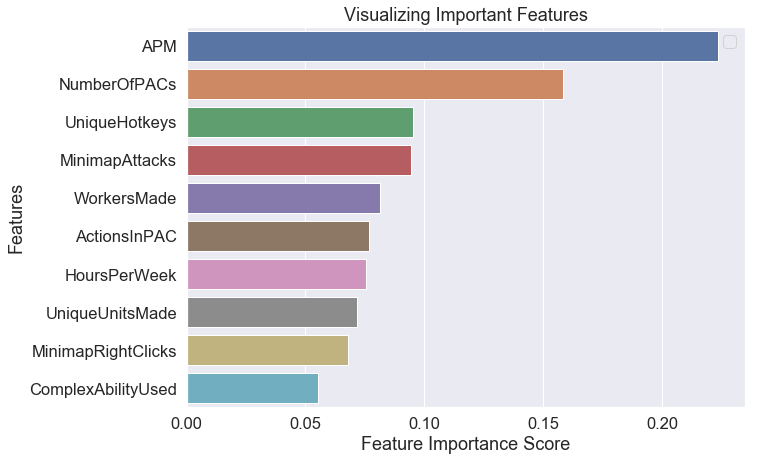

In [222]:
from matplotlib import figure
feature_imp = pd.Series(rfc.feature_importances_,index=X_train.columns, ).sort_values(ascending=False)
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(10,7))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

- Now this is pretty awesome. Not surprisingly, APM and NumberOfPACs are the most important features.
- Will definitely use some form of this plot.

### Random Forest Using GridSearchCV

In [107]:
# Number of trees in random forest
n_estimators = [10,30,100,300]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [108]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# 3 different combinations, and use all available cores
rf_grid = GridSearchCV(estimator = rf, param_grid = random_grid, 
                       cv = 5, verbose=2, n_jobs = -1, scoring=recallScorer)
# Fit the random search model
rf_grid.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 459 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 742 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 1107 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2079 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2686 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 3375 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 4144 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 4995 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 5926 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 6939 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 8032 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 30, 100, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(recall_score, average=None, labels=[3]),
       verbose=2)

- For the record, this process took a LONG time. 

In [110]:
# Print optimized scores
print('Best score for Random Forests:', rf_grid.best_score_)
print('Best Estimators:', rf_grid.best_estimator_.n_estimators)
print('Best Features:', rf_grid.best_estimator_.max_features)
print('Best Depth:', rf_grid.best_estimator_.max_depth)
print('Best Split:', rf_grid.best_estimator_.min_samples_split)
print('Best Leaves:', rf_grid.best_estimator_.min_samples_leaf)
print('Bootstrap?:', rf_grid.best_estimator_.bootstrap)

Best score for Random Forests: 0.9512799339388934
Best Estimators: 30
Best Features: sqrt
Best Depth: None
Best Split: 2
Best Leaves: 1
Bootstrap?: True


- VERY impressive score though. The best so far, at least before testing. 

In [111]:
# Train on the optimized parameters
rfc_best=RandomForestClassifier(n_estimators=30, max_features='sqrt', max_depth=None,
                                min_samples_split=2, min_samples_leaf=1, 
                                bootstrap=True, n_jobs=-1)
rfc_best.fit(X_train, y_train)
y_pred=rfc_best.predict(X_test)

### GridSearchCV Optimized Random Forest Test Score

In [112]:
print("Accuracy Score:", metrics.accuracy_score(y_test, y_pred))
print("Overall Recall:" , metrics.recall_score(y_test, y_pred, average=None))
print("Contender Class Recall:" , metrics.recall_score(y_test, y_pred, average=None, labels=[3]))

Accuracy Score: 0.6479713603818615
Overall Recall: [0.66064982 0.71801567 0.47752809]
Contender Class Recall: [0.47752809]


- Interesting. Decent Recall for other classes and overall accuracy score, but really bad Recally for Contender. 
- This strongly implies that the model __overfit heavily on train__. 
- Overall __Random Forests have not perfomed well for the most important class__.